In [1]:
from entsoe import EntsoePandasClient
import pandas as pd
from pandas import DataFrame
from datetime import timedelta, date
import numpy as np
import os.path
import requests
import datetime

In [2]:
client = EntsoePandasClient(api_key = "9c51aa38-46cc-44ea-a3f0-dd69525abd80")

os.makedirs(os.getcwd() + "/" + "entsoe_transparency_data", exist_ok = True)

path = os.getcwd() + "/" + "entsoe_transparency_data"

In [3]:
#set your dates!
start = pd.Timestamp('2022-01-10')
end = pd.Timestamp('2021-04-13')

country = "DE"

In [4]:
date_list = [(date.year, date.month) for date in pd.date_range(
    start=pd.Timestamp(start.year, start.month, 1), 
    end=pd.Timestamp(end.year, end.month+1, 1)-pd.Timedelta('1d'), 
    freq="m"
)]
#end=pd.Timestamp(end.year, end.month+1, 1)-pd.Timedelta('1d'), 

In [5]:
date_list

[(2022, 1), (2022, 2), (2022, 3), (2022, 4)]

In [43]:
for date in date_list:
    print(date)
    d_start = pd.Timestamp(year=date[0], month=date[1], day=1, tz='Europe/Brussels')
    print(d_start)
    d_end = pd.Timestamp(year=date[0], month=date[1] + 1, day=1, tz='Europe/Brussels')
    print(d_end)
    #df = client.query_generation_per_plant(tso["{}".format(country)], start=start,end=end, psr_type=None)
    

(2022, 1)
2022-01-01 00:00:00+01:00
2022-02-01 00:00:00+01:00
(2022, 2)
2022-02-01 00:00:00+01:00
2022-03-01 00:00:00+01:00
(2022, 3)
2022-03-01 00:00:00+01:00
2022-04-01 00:00:00+02:00
(2022, 4)
2022-04-01 00:00:00+02:00
2022-05-01 00:00:00+02:00


In [44]:
# monthly_list is filled with dates in the format required for the queery
year_start = 2020
year_end = 2022
month_start = 1
month_end =12
day_start = 1
day_end = 31
monthly_list = [] 
for year in list(range(year_start, year_end+1)):
    for month in range(month_start, month_end+1):
        if month == 12:
            days = pd.date_range(start="{}{}{}".format(year, "%.2d" % month, "%.2d" % day_start), 
                                 end="{}{}{}".format(year, "%.2d" % month, "%.2d" % day_end), freq="D").strftime("%Y%m%d")
        else:
            if day_end > 28:
                month_next = month+1
                days = pd.date_range(start="{}{}{}".format(year, "%.2d" % month, "%.2d" % day_start), 
                                     end="{}{}01".format(year, "%.2d" % month_next), freq="D")[:-1].strftime("%Y%m%d")
            else: 
                 days = pd.date_range(start="{}{}{}".format(year, "%.2d" % month, "%.2d" % day_start), 
                                      end="{}{}{}".format(year, "%.2d" % month, "%.2d" % day_end), freq="D").strftime("%Y%m%d")
        monthly_list.append(days)

In [45]:
# get generation data for all plants of an tso
def get_generation_data_tso (country, step):
    for dates in monthly_list[step:step+1]:
        filename = dates[0][:-2]
        file_path = os.path.join(path, country, filename)
        if os.path.exists(file_path):
            print(filename + " already exists")
        else:
            print(filename)
            os.makedirs(str(path) + "/" + str(country), exist_ok = True)
            country_path = os.path.join(path, str(country))
            start = pd.Timestamp(dates[0], tz='Europe/Brussels')
            end = pd.Timestamp(dates[-1], tz='Europe/Brussels')
            df = client.query_generation_per_plant(tso["{}".format(country)], start=start,end=end, psr_type=None)
            df.to_pickle("{}/{}".format(country_path, filename))

In [46]:
def get_data(country, step):
    for dates in monthly_list[step:step+1]:
        filename = dates[0][:-2]
        file_path = os.path.join(path, filename)
        print(file_path)
        if os.path.exists(file_path):
            print(filename + " already exists")
        else:
            start = pd.Timestamp(dates[0], tz='Europe/Brussels')
            end = pd.Timestamp(dates[-1], tz='Europe/Brussels') + pd.Timedelta('1d')
            print(start)
            print(end)
            df = client.query_generation(country, start=start, end=end, psr_type=None)
            df.to_pickle("{}".format(file_path))

In [49]:
for step in range(len(monthly_list)):
    try:
        print(step)
        get_data(country, step)
    except requests.exceptions.ConnectionError:
        print('failed')
        pass  

0
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202001
202001 already exists
1
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202002
202002 already exists
2
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202003
202003 already exists
3
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202004
202004 already exists
4
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202005
202005 already exists
5
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202006
202006 already exists
6
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202007
202007 already exists
7
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_transparency_data/202008
202008 already exists
8
/Users/Jarusch/Documents/Hertie/Task/energy_demand/top_down/entsoe_tra

In [50]:
# read pickles and save to df
def get_pickles(country):
    df_list = []
    for step in monthly_list[:28]:
        ts = pd.read_pickle("{}/{}".format(path, step[0][:-2]))
        df_list.append(ts)
    df = pd.concat(df_list, axis = 0)
    return df    

In [51]:
df = get_pickles(country)

In [55]:
df.resample("1d").sum()['Fossil Gas', 'Actual Aggregated']

2020-01-01 00:00:00+01:00    462386.0
2020-01-02 00:00:00+01:00    531120.0
2020-01-03 00:00:00+01:00    437843.0
2020-01-04 00:00:00+01:00    419687.0
2020-01-05 00:00:00+01:00    547980.0
                               ...   
2022-04-26 00:00:00+02:00    813619.0
2022-04-27 00:00:00+02:00    753303.0
2022-04-28 00:00:00+02:00    546042.0
2022-04-29 00:00:00+02:00    567994.0
2022-04-30 00:00:00+02:00    366160.0
Freq: D, Name: (Fossil Gas, Actual Aggregated), Length: 851, dtype: float64

In [56]:
ser = df.resample('1d').sum()['Fossil Gas', 'Actual Aggregated'] / 4
ser.name = 'electricity_from_gas'
ser = ser.tz_localize(None)
ser.to_csv('../data/electricity_from_gas.csv')

<AxesSubplot:>

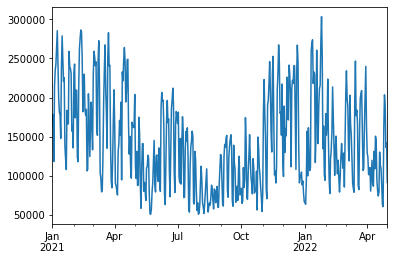

In [57]:
ser[ser.index.year>2020].plot()